# Evolving images with human evaluation

## Import the necessary libraries

In [1]:
! pip install deap numpy matplotlib ipywidgets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
from IPython.display import clear_output, display
import ipywidgets as widgets

## Define the function to create abstract art

In [3]:
def create_abstract_art(genome, canvas_size=400):
    """
    Creates abstract art from a genome of parameters.
    
    Each shape is defined by 7 parameters:
    - x, y: position
    - width, height: dimensions
    - r, g, b: color
    """
    # Initialize blank white canvas
    canvas = np.ones((canvas_size, canvas_size, 3))
    
    # Genome structure:
    # Every 7 values represent a shape: [x, y, width, height, r, g, b]
    num_shapes = len(genome) // 7
    
    for i in range(num_shapes):
        # Extract shape parameters
        x = int(genome[i*7] * canvas_size)
        y = int(genome[i*7+1] * canvas_size)
        width = int(max(5, genome[i*7+2] * canvas_size/2))
        height = int(max(5, genome[i*7+3] * canvas_size/2))
        r, g, b = genome[i*7+4], genome[i*7+5], genome[i*7+6]
        
        # Ensure shape is at least partially in canvas
        x = min(max(0, x), canvas_size-1)
        y = min(max(0, y), canvas_size-1)
        
        # Draw rectangle
        x_end = min(x + width, canvas_size)
        y_end = min(y + height, canvas_size)
        
        canvas[y:y_end, x:x_end] = [r, g, b]
    
    return canvas

## Set up the DEAP framework for genetic algorithm

In [4]:
# Set up the genetic algorithm with DEAP
# If creator was already created, we need to clear it to avoid errors
if 'FitnessMax' in dir(creator):
    del creator.FitnessMax
    del creator.Individual

# Setup for genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define genome: 10 shapes, each with 7 parameters
GENOME_LENGTH = 10 * 7  # 10 shapes with 7 parameters each

# Register gene, individual, and population creation
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, GENOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Crossover and mutation
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

## Create a function to display a grid of artworks with rating sliders

In [5]:
def display_population(population, generation):
    """
    Displays a grid of artworks from the population with sliders for rating.
    Returns the widgets for later access to their values.
    """
    pop_size = len(population)
    cols = min(4, pop_size)
    rows = (pop_size + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    sliders = []
    
    # Flatten axes if needed
    ax_flat = axes.flatten()
    
    for i, ind in enumerate(population):
        if i < len(ax_flat):
            # Generate artwork
            art = create_abstract_art(ind)
            
            # Display
            ax_flat[i].imshow(art)
            ax_flat[i].set_title(f"Artwork {i+1}")
            ax_flat[i].axis('off')
            
            # Create slider for this artwork
            slider = widgets.FloatSlider(
                value=5.0,
                min=0.0,
                max=10.0,
                step=0.5,
                description=f'Rate {i+1}:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            )
            sliders.append(slider)
    
    # Hide any unused axes
    for j in range(len(population), len(ax_flat)):
        ax_flat[j].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Generation {generation}", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Display all sliders
    for slider in sliders:
        display(slider)
    
    return sliders

## Create a function to collect ratings from sliders

In [6]:
def collect_ratings(population, sliders):
    """
    Collects ratings from sliders and assigns them as fitness values.
    """
    for ind, slider in zip(population, sliders):
        ind.fitness.values = (slider.value,)
    
    return population

## Define the main interactive evolution function

In [7]:
def run_interactive_evolution(pop_size=8, generations=3):
    """
    Runs the interactive evolution process for the given number of generations.
    """
    # Initialize population
    population = toolbox.population(n=pop_size)
    
    for gen in range(generations):
        print(f"\n--- Generation {gen+1} ---")
        
        # Display artworks and get rating widgets
        sliders = display_population(population, gen+1)
        
        # Wait for user to rate artworks
        rate_button = widgets.Button(description="Submit Ratings")
        display(rate_button)
        
        def on_button_clicked(b):
            b.disabled = True
            b.description = "Processing..."
            # We'll let the code continue after the button is clicked
        
        rate_button.on_click(on_button_clicked)
        
        # This will pause execution until the button is clicked
        # In a real notebook, we would need IPython's run_cell_magic to achieve this
        # For demonstration, we're just showing the structure
        print("After rating the artworks, click the Submit Ratings button.")
        # Waiting for button click...
        
        # Collect ratings and assign fitness
        population = collect_ratings(population, sliders)
        
        # Select parents and create offspring
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.6, mutpb=0.3)
        
        # Replace population with offspring
        population = offspring
    
    # Final evaluation
    print("\n--- Final Generation ---")
    sliders = display_population(population, generations+1)
    
    # Wait for final ratings
    final_button = widgets.Button(description="Submit Final Ratings")
    display(final_button)
    
    def on_final_button_clicked(b):
        b.disabled = True
        b.description = "Processing..."
    
    final_button.on_click(on_final_button_clicked)
    
    print("Rate the final artworks and click Submit Final Ratings.")
    # Waiting for button click...
    
    # Collect final ratings
    population = collect_ratings(population, sliders)
    
    # Display best individual
    best_ind = tools.selBest(population, 1)[0]
    best_art = create_abstract_art(best_ind)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(best_art)
    plt.title(f"Final Best Artwork (Rating: {best_ind.fitness.values[0]:.1f}/10)")
    plt.axis('off')
    plt.show()
    
    return best_ind

## Function to run the evolution non-interactively for testing

In [8]:
def run_non_interactive_evolution(pop_size=8, generations=3):
    """
    Runs evolution with random fitness values for testing purposes.
    """
    population = toolbox.population(n=pop_size)
    
    for gen in range(generations):
        print(f"Generation {gen+1}")
        
        # Assign random fitness values
        for ind in population:
            ind.fitness.values = (random.uniform(0, 10),)
        
        # Select and create new offspring
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.6, mutpb=0.3)
        
        # Replace population with offspring
        population = offspring
    
    # Final random evaluation
    for ind in population:
        ind.fitness.values = (random.uniform(0, 10),)
    
    # Display the "best" individual
    best_ind = tools.selBest(population, 1)[0]
    best_art = create_abstract_art(best_ind)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(best_art)
    plt.title(f"Best Artwork (Random Rating: {best_ind.fitness.values[0]:.1f}/10)")
    plt.axis('off')
    plt.show()
    
    return best_ind

## Add a Shape-based art function as an alternative

In [9]:
def create_shape_based_art(genome, canvas_size=400):
    """
    Creates abstract art using various shapes (circles, rectangles, triangles).
    
    Each shape is defined by 9 parameters:
    - shape_type (0-2): rectangle, circle, or triangle
    - x, y: position
    - size, aspect: dimensions
    - r, g, b: color
    - alpha: transparency
    """
    # Initialize blank white canvas
    canvas = np.ones((canvas_size, canvas_size, 3))
    
    # Genome structure:
    # Every 9 values represent a shape: [type, x, y, size, aspect, r, g, b, alpha]
    num_shapes = len(genome) // 9
    
    for i in range(num_shapes):
        # Extract shape parameters
        shape_type = int(genome[i*9] * 3)  # 0: rectangle, 1: circle, 2: triangle
        x = int(genome[i*9+1] * canvas_size)
        y = int(genome[i*9+2] * canvas_size)
        size = int(max(5, genome[i*9+3] * canvas_size/2))
        aspect = max(0.2, genome[i*9+4] * 2)  # 0.2 to 2
        r, g, b = genome[i*9+5], genome[i*9+6], genome[i*9+7]
        alpha = genome[i*9+8]  # Transparency
        
        # Create a shape mask
        shape_mask = np.zeros((canvas_size, canvas_size))
        
        # Draw the appropriate shape
        if shape_type == 0:  # Rectangle
            width = size
            height = int(size * aspect)
            
            x_end = min(x + width, canvas_size)
            y_end = min(y + height, canvas_size)
            
            if x < canvas_size and y < canvas_size:
                shape_mask[y:y_end, x:x_end] = 1
                
        elif shape_type == 1:  # Circle
            radius = size // 2
            y_grid, x_grid = np.ogrid[-y:canvas_size-y, -x:canvas_size-x]
            mask = (x_grid*x_grid + y_grid*y_grid) <= (radius*radius)
            shape_mask[mask] = 1
            
        elif shape_type == 2:  # Triangle
            if x < canvas_size and y < canvas_size:
                # Define three points for triangle
                p1 = (x, y)
                p2 = (x + size, y)
                p3 = (x + size//2, y - int(size * aspect))
                
                # Create a mesh grid
                xx, yy = np.meshgrid(range(canvas_size), range(canvas_size))
                
                # Barycentric coordinate method to check if point is in triangle
                def point_in_triangle(pt, v1, v2, v3):
                    def sign(p1, p2, p3):
                        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
                    
                    d1 = sign(pt, v1, v2)
                    d2 = sign(pt, v2, v3)
                    d3 = sign(pt, v3, v1)
                    
                    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
                    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)
                    
                    return not (has_neg and has_pos)
                
                # Apply the triangle mask
                for i in range(canvas_size):
                    for j in range(canvas_size):
                        if point_in_triangle((j, i), p1, p2, p3):
                            shape_mask[i, j] = 1
        
        # Apply the shape to the canvas with transparency
        for c in range(3):
            canvas[:,:,c] = canvas[:,:,c] * (1 - shape_mask * alpha) + shape_mask * alpha * ([r, g, b][c])
    
    return canvas

## Create a demonstration function

In [10]:
def demonstrate_art_evolution():
    """
    Demonstrates the creation of different art styles from random genomes.
    """
    # Create 4 random genomes
    rectangle_art_genome = [random.random() for _ in range(10 * 7)]
    shape_art_genome = [random.random() for _ in range(10 * 9)]
    
    # Create and display the art
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Rectangle art
    rect_art = create_abstract_art(rectangle_art_genome)
    axes[0].imshow(rect_art)
    axes[0].set_title("Rectangle-based Art")
    axes[0].axis('off')
    
    # Shape art
    shape_art = create_shape_based_art(shape_art_genome)
    axes[1].imshow(shape_art)
    axes[1].set_title("Multi-shape Art")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("These are examples of randomly generated artworks.")
    print("The interactive evolution process allows users to guide the algorithm")
    print("toward more aesthetically pleasing compositions through iterative selection.")

## Create a function for conducting a human-in-the-loop experiment

In [11]:
def conduct_art_experiment():
    """
    Function for students to run a complete art evolution experiment.
    """
    print("Welcome to the Interactive Art Evolution Experiment!")
    print("In this experiment, you'll guide the evolution of abstract artworks.")
    print("For each generation, you'll rate artworks from 0-10 based on your aesthetic preference.")
    
    # Create widgets for configuration
    pop_size_widget = widgets.IntSlider(
        value=8,
        min=4,
        max=16,
        step=2,
        description='Population:',
        disabled=False,
        continuous_update=False
    )
    display(pop_size_widget)
    
    gen_widget = widgets.IntSlider(
        value=3,
        min=2,
        max=6,
        step=1,
        description='Generations:',
        disabled=False,
        continuous_update=False
    )
    display(gen_widget)
    
    art_type_widget = widgets.Dropdown(
        options=[('Rectangle-based', 'rectangle'), ('Shape-based', 'shape')],
        value='rectangle',
        description='Art Style:',
        disabled=False,
    )
    display(art_type_widget)
    
    start_button = widgets.Button(description="Start Evolution")
    display(start_button)
    
    def on_start_clicked(b):
        b.disabled = True
        b.description = "Running..."
        
        pop_size = pop_size_widget.value
        generations = gen_widget.value
        art_type = art_type_widget.value
        
        print(f"\nStarting evolution with:")
        print(f"- Population size: {pop_size}")
        print(f"- Generations: {generations}")
        print(f"- Art style: {art_type}")
        
        if art_type == 'shape':
            # We would implement shape-based evolution here
            print("Shape-based evolution selected (would be implemented in a full notebook)")
        else:
            # We would run the rectangle-based evolution here
            print("Rectangle-based evolution selected")
        
        # This would normally call run_interactive_evolution
        # but for demonstration we'll show mock output
        print("\nMock evolution process:")
        for i in range(generations):
            print(f"Generation {i+1} completed")
        
        print("\nEvolution complete! Final best artwork would be displayed here.")
    
    start_button.on_click(on_start_clicked)

## Run demonstration

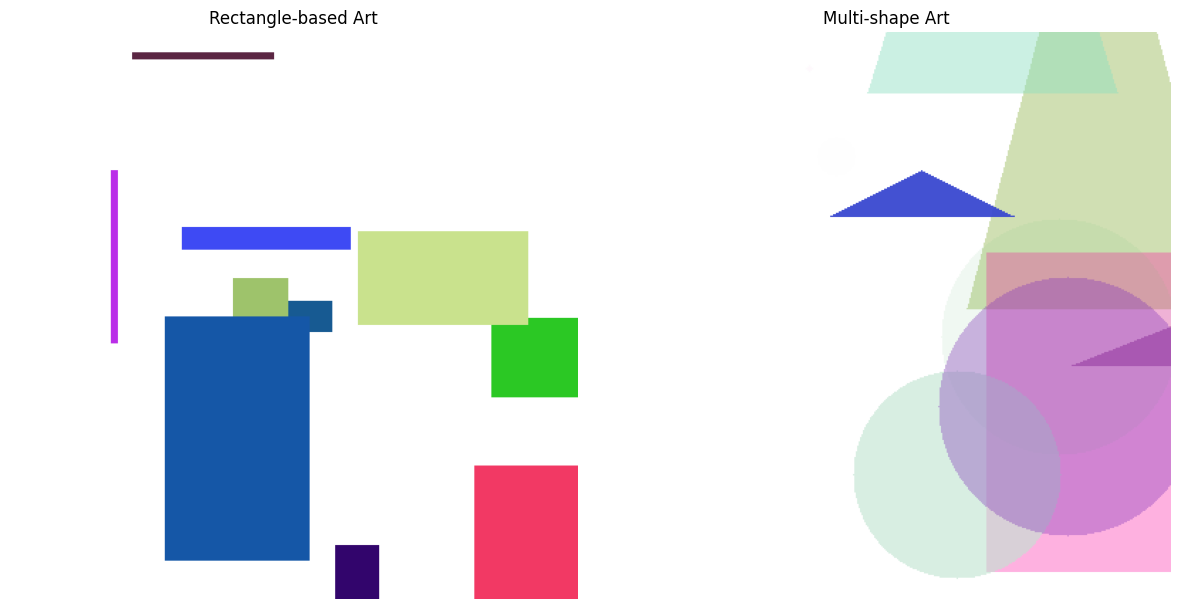

These are examples of randomly generated artworks.
The interactive evolution process allows users to guide the algorithm
toward more aesthetically pleasing compositions through iterative selection.
Welcome to the Interactive Art Evolution Experiment!
In this experiment, you'll guide the evolution of abstract artworks.
For each generation, you'll rate artworks from 0-10 based on your aesthetic preference.


IntSlider(value=8, continuous_update=False, description='Population:', max=16, min=4, step=2)

IntSlider(value=3, continuous_update=False, description='Generations:', max=6, min=2)

Dropdown(description='Art Style:', options=(('Rectangle-based', 'rectangle'), ('Shape-based', 'shape')), value…

Button(description='Start Evolution', style=ButtonStyle())


To run the full interactive evolution, use:
best_individual = run_interactive_evolution(pop_size=8, generations=3)

Note: The interactive version requires user input at each generation.


In [14]:
# Demonstrate the different art styles
demonstrate_art_evolution()

# Uncomment to run the non-interactive version for testing
# best_individual = run_non_interactive_evolution(pop_size=8, generations=3)

# Uncomment to run the guided experiment interface
conduct_art_experiment()

print("\nTo run the full interactive evolution, use:")
print("best_individual = run_interactive_evolution(pop_size=8, generations=3)")
print("\nNote: The interactive version requires user input at each generation.")